In [1]:
import torch
import numpy as np
import os
from tqdm import tqdm
from ultis.PointCloudDataLoader import PointCloudDataLoader
from feature_to_skeleton import makeSkeleton
from pointnet2_ssg_wo_normals.pointnet2_cls_ssg import get_model as get_model_ssg
from pointnet2_msg_normals.pointnet2_cls_msg import get_model as get_model_msg, get_loss

(1024,)
torch.Size([1024])
torch.Size([51])


d:\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = 'data_196' #change path

In [3]:
data_train = PointCloudDataLoader(root= path, split = "train", num_pcs = 196, startIndex_split=0, endIndex_split=20) #skip index if you use all dataset

(20, 6, 196)


In [4]:
ratio = 0.8
data_train, data_validate = torch.utils.data.random_split(data_train, [int(len(data_train) * ratio), len(data_train) - int(len(data_train) * ratio)])

In [5]:
#change batch_size
trainDataLoader = torch.utils.data.DataLoader(data_train, batch_size=2, shuffle=True)
validateDataLoader = torch.utils.data.DataLoader(data_validate, batch_size=2, shuffle=False)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
checkpoint = torch.load('pointnet2_msg_normals\checkpoints\\best_model.pth')
model = get_model_msg(num_class=40)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model = model.to(device)

In [8]:
modelSkeleton = makeSkeleton()
modelSkeleton = modelSkeleton.to(device)

In [9]:
criterion = torch.nn.L1Loss(reduce = 'mean')
optimizer = torch.optim.Adam(
            model.parameters(),
            lr=0.01,
            betas=(0.9, 0.999),
            eps=1e-08,
            weight_decay=0.0001
        )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
global_epoch = 0
global_step = 0
best_instance_acc = 0.0
best_class_acc = 0.0
#define epoch
start_epoch = 0 #or checkpoint['epoch']
end_epoch = 20 

d:\miniconda3\envs\torch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [10]:
import ultis.provider as provider

In [14]:
min_loss = 0.0
for epoch in range(start_epoch, end_epoch):
    running_train_loss = 0.0
    model = model.train()
    scheduler.step()
    for id, (points, target) in tqdm(enumerate(trainDataLoader, 0), total=len(trainDataLoader), smoothing=0.9):
        optimizer.zero_grad()
        points = points.transpose(2,1)
        points = points.cpu().numpy()
        
        points = provider.random_point_dropout(points)
        points[:, :, 0:3] = provider.random_scale_point_cloud(points[:, :, 0:3])
        points[:, :, 0:3] = provider.shift_point_cloud(points[:, :, 0:3])
        points = torch.Tensor(points)
        points = points.transpose(2,1)
        
        #change to cuda
        points, target = points.to(device), target.to(device)


        trans, features = model(points)
        features = torch.reshape(features, (features.shape[0], 1024))
        features = features.to(device)

        pred_skeleton = modelSkeleton(features)

        loss = criterion(torch.flatten(pred_skeleton), torch.flatten(target))
        #print(f'loss is: {loss}')
        loss.backward()
        optimizer.step()
        global_step += 1
        running_train_loss += loss.item()
    print(f"Epoch {epoch} end. Loss is {running_train_loss/len(trainDataLoader)}")
    model = model.eval()
    running_vaild_loss = 0.0
    with torch.no_grad():
      for id, (points, target) in tqdm(enumerate(validateDataLoader, 0), total=len(validateDataLoader)):


        points, target = points.to(device), target.to(device)
        trans, features = model(points)
        features = torch.reshape(features, (features.shape[0], 1024))
        features = features.to(device)

        pred_skeleton = modelSkeleton(features)

        loss = criterion(torch.flatten(pred_skeleton), torch.flatten(target))
        #print(f'loss is: {loss}')
        running_vaild_loss += loss.item()
      excepted_loss = running_vaild_loss/len(validateDataLoader)
      print(f"Vaild is: {excepted_loss}", end = '. ')
      if epoch == start_epoch or excepted_loss < min_loss:
        print(f"Loss is lower than lowest loss: {min_loss}. Saving model...")
        min_loss = excepted_loss
        torch.save(model.state_dict(), f"save_model/model.pth")
        torch.save(modelSkeleton.state_dict(), f"save_model/modelSkeleton.pth")
        print(f"Model saved at save_model/model.pth save_model/modelSkeleton.pth",end='')
      print()


100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


Epoch 0 end. Loss is 0.2231395523995161


100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


Vaild is: 0.2638288736343384. Loss is lower than lowest loss: 0.0. Saving model...
Model saved at save_model/model.pth save_model/modelSkeleton.pth


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 1 end. Loss is 0.2276439480483532


100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Vaild is: 0.24360495805740356. Loss is lower than lowest loss: 0.2638288736343384. Saving model...
Model saved at save_model/model.pth save_model/modelSkeleton.pth


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


Epoch 2 end. Loss is 0.2247332949191332


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]


Vaild is: 0.2782020717859268. 


100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


Epoch 3 end. Loss is 0.21090286038815975


100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


Vaild is: 0.2809007912874222. 


100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


Epoch 4 end. Loss is 0.2162171397358179


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


Vaild is: 0.28422942757606506. 


100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


Epoch 5 end. Loss is 0.21958418749272823


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


Vaild is: 0.2895266115665436. 


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


Epoch 6 end. Loss is 0.1996298562735319


100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


Vaild is: 0.22431885451078415. Loss is lower than lowest loss: 0.24360495805740356. Saving model...
Model saved at save_model/model.pth save_model/modelSkeleton.pth


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 7 end. Loss is 0.20677724294364452


100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


Vaild is: 0.2510383576154709. 


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 8 end. Loss is 0.18559540435671806


100%|██████████| 2/2 [00:00<00:00,  3.65it/s]


Vaild is: 0.2674129754304886. 


100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


Epoch 9 end. Loss is 0.19030687026679516


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


Vaild is: 0.27871477603912354. 


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 10 end. Loss is 0.18383751064538956


100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Vaild is: 0.2725010812282562. 


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Epoch 11 end. Loss is 0.2124041933566332


100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Vaild is: 0.28318899869918823. 


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Epoch 12 end. Loss is 0.19823336973786354


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


Vaild is: 0.24265054613351822. 


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]


Epoch 13 end. Loss is 0.1894356980919838


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]


Vaild is: 0.18230099231004715. Loss is lower than lowest loss: 0.22431885451078415. Saving model...
Model saved at save_model/model.pth save_model/modelSkeleton.pth


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 14 end. Loss is 0.19118625298142433


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]


Vaild is: 0.184634268283844. 


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


Epoch 15 end. Loss is 0.18361712247133255


100%|██████████| 2/2 [00:00<00:00,  3.89it/s]


Vaild is: 0.18300247192382812. 


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


Epoch 16 end. Loss is 0.17663046903908253


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


Vaild is: 0.19131536036729813. 


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Epoch 17 end. Loss is 0.21194584295153618


100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


Vaild is: 0.22756798565387726. 


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 18 end. Loss is 0.17308819480240345


100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


Vaild is: 0.2208707183599472. 


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Epoch 19 end. Loss is 0.17041432484984398


100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

Vaild is: 0.2190317064523697. 


FIND TEST LOSS:

In [63]:
def testLoss(testDataLoader, model, skeletonModel):
    running_vaild_loss = 0.0
    with torch.no_grad():
      for id, (points, target) in tqdm(enumerate(testDataLoader, 0), total=len(testDataLoader)):


        points, target = points.to(device), target.to(device)
        trans, features = model(points)
        features = torch.reshape(features, (features.shape[0], 1024))
        features = features.to(device)

        pred_skeleton = modelSkeleton(features)

        loss = criterion(torch.flatten(pred_skeleton), torch.flatten(target))
        #print(f'loss is: {loss}')
        running_vaild_loss += loss.item()
      excepted_loss = running_vaild_loss/len(testDataLoader)
      print(f"Loss of test file is: {excepted_loss}", end = '. ')

In [58]:
data_test = PointCloudDataLoader(root= path, split = "test", num_pcs = 196, startIndex_split=0, endIndex_split=20) #skip index if you use all dataset

(20, 6, 196)


In [59]:
testDataLoader = torch.utils.data.DataLoader(data_test, batch_size=1, shuffle=True)

In [64]:
testLoss(testDataLoader, model, modelSkeleton)

100%|██████████| 20/20 [00:05<00:00,  3.73it/s]

Loss of test file is: 0.19079884514212608. 

TEST ONE POINT CLOUD:

In [15]:
a = np.load('data_196\X_train.npy')

(14, 14, 5)


In [32]:
b = np.load('data_196/y_train.npy')

In [16]:
pc = a[0].reshape(196,5)
print(pc.shape)

(196, 5)


In [41]:
def get_feature(pc):
    with torch.no_grad():
        pc = pc.reshape(1, 196, 5)
        pc = np.transpose(pc, (0, 2, 1))
        pc = np.insert(pc, 5, 0, axis = 1)
        pc = pc.astype(np.float32)
        pc = torch.tensor(pc)
        pc = pc.to(device)
        output, features = model(pc)
        features = torch.reshape(features, (features.shape[0], 1024))
        features = features.to(device)

        pred_skeleton = modelSkeleton(features)
        pred_skeleton = pred_skeleton.cpu().numpy()
        pred_skeleton = pred_skeleton.reshape(17, 3)
        return pred_skeleton

In [42]:
pred_skeleton = get_feature(pc)

In [43]:
true_skeleton.shape

(17, 3)

In [46]:
pred_skeleton = pred_skeleton.reshape(17, 3)

In [47]:
pred_skeleton.shape

(17, 3)

In [54]:
import matplotlib.pyplot as plt
def visualize(data_pc, pred_label, true_label):
        #data_pcs = np.load("D:\Documents\AIProject\HAR\pointnet2\Pointnet_Pointnet2_pytorch\log\classification\data_196\X_test.npy")
        #pred_labels = np.load('D:\Documents\AIProject\HAR\pointnet2\Pointnet_Pointnet2_pytorch\log\classification\data_196\y_test.npy')

        fig, axs = plt.subplots(1, 3, figsize=(15, 10), subplot_kw={'projection': '3d'})
        axs[0].clear()
        axs[0].scatter(data_pc[:, 0], data_pc[:,2], data_pc[:,1])  
        axs[0].set_xlim(-2, 2)
        axs[0].set_ylim(0, 6)
        axs[0].set_zlim(-2, 2)
        axs[0].set_xlabel('X')
        axs[0].set_ylabel('Y')
        axs[0].set_zlabel('Z')
        axs[0].view_init(10, -100)
        axs[0].set_xticks([-2, -1, 0, 1, 2])
        axs[0].set_yticks([0, 2, 4, 6])
        axs[0].set_zticks([-2, -1, 0, 1, 2])

        axs[1].clear()
        axs[1].scatter(pred_label[:, 0], pred_label[:,2], pred_label[:,1])  
        axs[1].set_xlim(-2, 2)
        axs[1].set_ylim(0, 6)
        axs[1].set_zlim(-2, 2)
        axs[1].set_xlabel('X')
        axs[1].set_ylabel('Y')
        axs[1].set_zlabel('Z')
        axs[1].view_init(10, -100)
        axs[1].set_xticks([-2, -1, 0, 1, 2])
        axs[1].set_yticks([0, 2, 4, 6])
        axs[1].set_zticks([-2, -1, 0, 1, 2])

        axs[2].clear()
        axs[2].scatter(true_label[:, 0], true_label[:,2], true_label[:,1])
        axs[2].set_xlim(-2, 2)
        axs[2].set_ylim(0, 6)
        axs[2].set_zlim(-2, 2)
        axs[2].set_xlabel('X')
        axs[2].set_ylabel('Y')
        axs[2].set_zlabel('Z')
        axs[2].view_init(10, -100)
        axs[2].set_xticks([-2, -1, 0, 1, 2])
        axs[2].set_yticks([0, 2, 4, 6])
        axs[2].set_zticks([-2, -1, 0, 1, 2])


        plt.show()

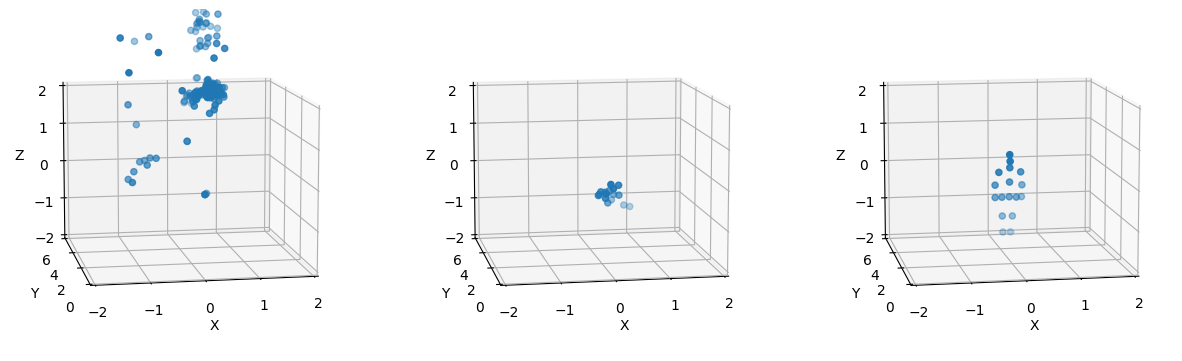

In [55]:
visualize(pc, pred_skeleton, true_skeleton)